In [1]:
from torch.quasirandom import SobolEngine
from hydra.utils import instantiate
from omegaconf import DictConfig, OmegaConf
import hydra
import torch
import botorch
import wandb
from botorch.models.transforms import Standardize
from botorch.models.transforms.input import Normalize
from mgp_models.fully_bayesian import  MGPFullyBayesianSingleTaskGP
from mgp_models.fit_fully_bayesian import fit_fully_bayesian_mgp_model_nuts, fit_partially_bayesian_mgp_model
from mgp_models.utils import *
from mgp_models.acquisition import *
from mgp_models.test_functions import *
import time
import scipy
from torchrl.modules import TruncatedNormal
import numpy as np

c:\Users\felip\anaconda3\envs\bo-cuda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\felip\anaconda3\envs\bo-cuda\Lib\site-packages\torchrl\data\replay_buffers\samplers.py:37: UserWarning: Failed to import torchrl C++ binaries. Some modules (eg, prioritized replay buffers) may not work with your installation. If you installed TorchRL from PyPI, please report the bug on TorchRL github. If you installed TorchRL locally and/or in development mode, check that you have all the required compiling packages.
  warnings.warn(EXTENSION_WARNING)


In [2]:
import math
from typing import Optional

from botorch.acquisition.monte_carlo import MCAcquisitionFunction
from botorch.acquisition import AnalyticAcquisitionFunction
from botorch.models.model import Model
from botorch.sampling.base import MCSampler
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.utils import t_batch_mode_transform
from torch import Tensor
import torch

from botorch.acquisition import AnalyticAcquisitionFunction
from mgp_models.fully_bayesian import  MGPFullyBayesianSingleTaskGP
from botorch.posteriors.fully_bayesian import GaussianMixturePosterior, MCMC_DIM

In [3]:
import random

random.seed(10)

In [5]:
tkwargs = {
"device": torch.device("cpu" if torch.cuda.is_available() else "cpu"),
"dtype": torch.double,
}

In [356]:
X = SobolEngine(dimension=1, scramble=True, seed=55).draw(4).to(**tkwargs)
X = torch.tensor(np.arange(0.1,1,1/5)).unsqueeze(-1)

In [357]:
X

tensor([[0.1000],
        [0.3000],
        [0.5000],
        [0.7000],
        [0.9000]], dtype=torch.float64)

In [358]:
Y = torch.sin(X*2*3.14)

In [359]:
Y

tensor([[ 0.5875],
        [ 0.9514],
        [ 0.0016],
        [-0.9504],
        [-0.5901]], dtype=torch.float64)

In [360]:
x = SobolEngine(dimension=1, scramble=True, seed=55).draw(3).to(**tkwargs)
x

tensor([[0.7465],
        [0.1126],
        [0.4282]], dtype=torch.float64)

In [361]:
train_Y = Y  # Flip the sign since we want to minimize f(x)
gp = MGPFullyBayesianSingleTaskGP(
        train_X=X, 
        train_Y=train_Y, 
        #train_Yvar=torch.full_like(train_Y, 1e-6),
        #input_transform=Normalize(d=cfg.functions.dim, bounds=bountensor_scaledds),
        outcome_transform=Standardize(m=1)
    )

ll = fit_fully_bayesian_mgp_model_nuts(gp,
                                            warmup_steps=256,
                                            num_samples=128 ,
                                            thinning=6,
                                            disable_progbar=False)

Warmup:   1%|          | 4/384 [00:00, 26.31it/s, step size=7.88e-02, acc. prob=0.498]

Sample: 100%|██████████| 384/384 [00:25, 15.12it/s, step size=2.78e-01, acc. prob=0.846]

{'lengthscale': tensor([[9.7705e-01],
        [7.7191e-01],
        [6.4682e+00],
        [1.4254e+00],
        [1.3188e+01],
        [2.9828e-02],
        [9.7011e-02],
        [4.2982e-01],
        [8.8349e+00],
        [3.0188e+03],
        [8.9023e+00],
        [6.4820e+00],
        [1.3582e+00],
        [5.6226e+01],
        [9.0305e-01],
        [3.3669e+00],
        [2.6631e+00],
        [1.2631e+02],
        [2.3367e+00],
        [5.1097e+00],
        [5.9298e-01],
        [5.1389e-01]], dtype=torch.float64), 'noise': tensor([0.6421, 0.8897, 1.6173, 0.1381, 1.0840, 0.6018, 0.2774, 0.0786, 0.5091,
        0.9405, 0.7720, 0.8380, 0.3818, 1.4789, 0.1943, 0.8253, 5.9379, 1.9203,
        2.6118, 0.2448, 1.4093, 0.1546], dtype=torch.float64), 'outputscale': tensor([6.4490, 6.9732, 8.8848, 5.9131, 6.7754, 7.7030, 5.6673, 5.7270, 6.8963,
        7.5154, 5.6395, 6.7594, 7.2880, 8.9579, 6.6637, 6.1236, 6.4939, 6.1088,
        5.2699, 8.5278, 9.3621, 7.4845], dtype=torch.float64), 'mean':

In [362]:
torch.zeros(10)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [363]:
test_X = torch.from_numpy(np.arange(0,1,1/10000))
posterior = gp.posterior(test_X)
Y_full = posterior.mean

In [364]:
Y_full.size()

torch.Size([22, 10000, 1])

In [365]:
Y

tensor([[ 0.5875],
        [ 0.9514],
        [ 0.0016],
        [-0.9504],
        [-0.5901]], dtype=torch.float64)

In [366]:
import matplotlib.pyplot as plt
import seaborn as sns

In [367]:
index1=7
index2=1
index3=11

In [393]:
index1=6
index2=1
index3=5

In [394]:
x = test_X.numpy()
y1 = Y_full[index1,:].detach().squeeze().numpy()
y2 = Y_full[index2,:].detach().squeeze().numpy()
y3 = Y_full[index3,:].detach().squeeze().numpy()

In [395]:
y1

array([ 0.27925289,  0.27956488,  0.27987694, ..., -0.28168936,
       -0.28137563, -0.28106199])

In [403]:
selected_x = 0.78

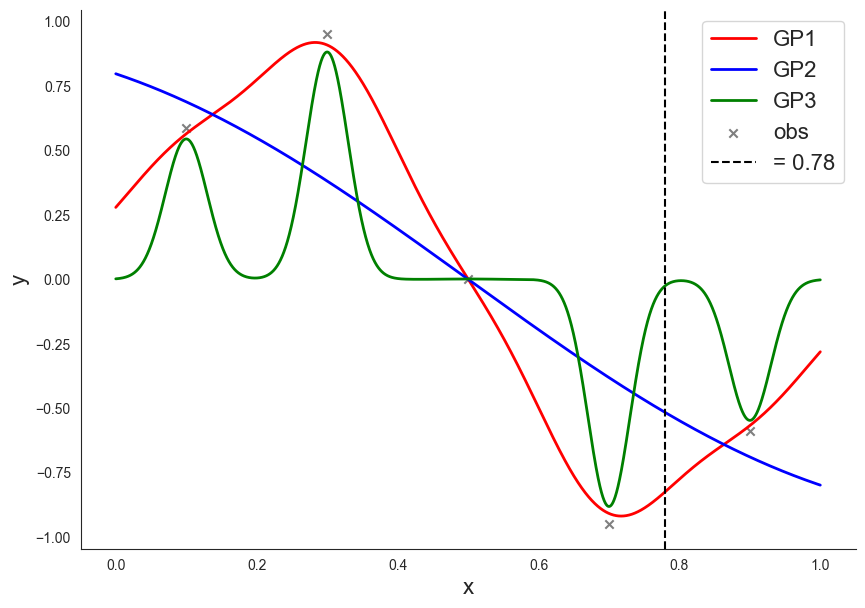

In [457]:
# Set the aesthetic style of the plots without grid
sns.set_style("white")

# Creating the plot with seaborn's styling, without grid
plt.figure(figsize=(10, 7))
plt.plot(x, y1, 'r', label='GP1', linewidth=2)
plt.plot(x, y2, 'b', label='GP2', linewidth=2)
plt.plot(x, y3, 'g', label='GP3', linewidth=2)
plt.scatter(X, Y, color='black', label='obs', alpha=0.5, marker="x") 
plt.axvline(x=selected_x, color='black', linestyle='--', label=f'= {selected_x}')
# Adding titles and labels with seaborn style, without grid
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.legend(fontsize=16)
sns.despine()  # Ensures the top and right spines are removed
plt.savefig('different_gps.png')
# Show the plot without grid
plt.show()


In [402]:
y1

array([ 0.27925289,  0.27956488,  0.27987694, ..., -0.28168936,
       -0.28137563, -0.28106199])

In [405]:
with torch.no_grad():
    observed_pred = gp.likelihood(gp(torch.tensor([selected_x])))

    # All relevant settings for using CIQ.
    #   ciq_samples(True) - Use CIQ for sampling
    #   num_contour_quadrature(10) -- Use 10 quadrature sites (Q in the paper)
    #   minres_tolerance -- error tolerance from minres (here, <0.01%).

    print("Running with Cholesky")
    # Make sure we use Cholesky
    with gpytorch.settings.fast_computations(covar_root_decomposition=False):
        %time y_samples = observed_pred.rsample(sample_shape=torch.Size([100000]))


Running with Cholesky
CPU times: total: 594 ms
Wall time: 103 ms


In [406]:
y_samples.size()

torch.Size([100000, 22, 1])

In [407]:
y_samples[:,index1].squeeze().numpy().size()

TypeError: 'int' object is not callable

In [408]:
y1_sampled = y_samples[:,index1].squeeze().numpy()
y2_sampled = y_samples[:,index2].squeeze().numpy()
y3_sampled = y_samples[:,index3].squeeze().numpy()

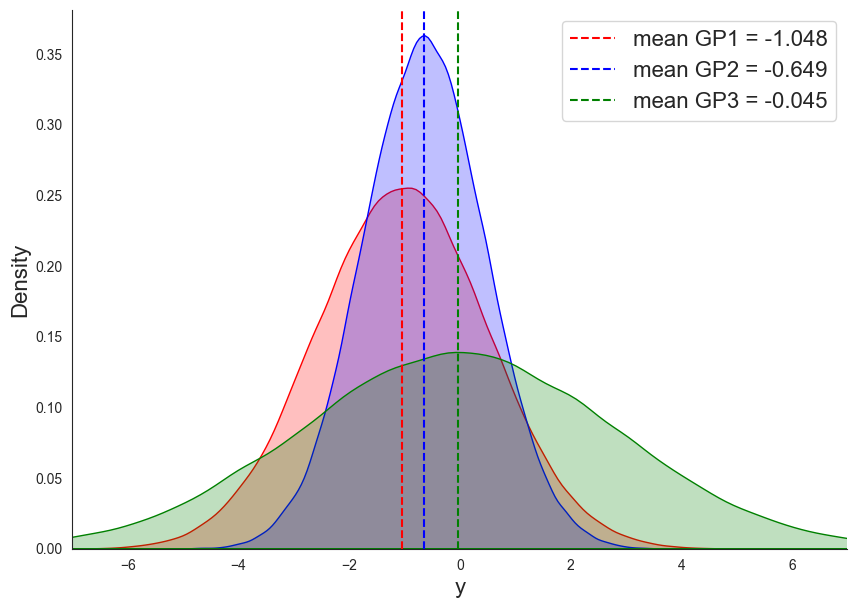

In [455]:
plt.figure(figsize=(10, 7))
sns.kdeplot(y1_sampled, color="red", fill=True)
plt.axvline(x=y1_sampled.mean(), color='red', linestyle='--', label=f'mean GP1 = {round(y1_sampled.mean(),3)}')
sns.kdeplot(y2_sampled, color="blue", fill=True)
plt.axvline(x=y2_sampled.mean(), color='blue', linestyle='--', label=f'mean GP2 = {round(y2_sampled.mean(),3)}')
sns.kdeplot(y3_sampled, color="green", fill=True)
plt.axvline(x=y3_sampled.mean(), color='green', linestyle='--', label=f'mean GP3 = {round(y3_sampled.mean(),3)}')
plt.legend(fontsize=16)
plt.xlabel("y", fontsize=16)
plt.ylabel("Density", fontsize=16)
plt.xlim(-7, 7)  # Set x-axis limits
sns.despine() 
plt.savefig('mixture_posteriors.png')
plt.grid(False)  # Ensure grid remains removed
plt.show()


In [438]:
mu_gmm = (y1_sampled.mean() + y2_sampled.mean()  + y3_sampled.mean())/3

In [439]:
mu_gmm

-0.5805688993034734

In [440]:
mean_var_gmm = (y1_sampled.var() + y2_sampled.var()  + y3_sampled.var())/3

In [444]:
diff_means = (mu_gmm - y1_sampled.mean())**2 + (mu_gmm - y2_sampled.mean())**2 + (mu_gmm - y3_sampled.mean())**2

In [445]:
var_gmm = mean_var_gmm + diff_means/3

In [446]:
MM_normal = np.random.normal(mu_gmm, np.sqrt(var_gmm), size=100000)

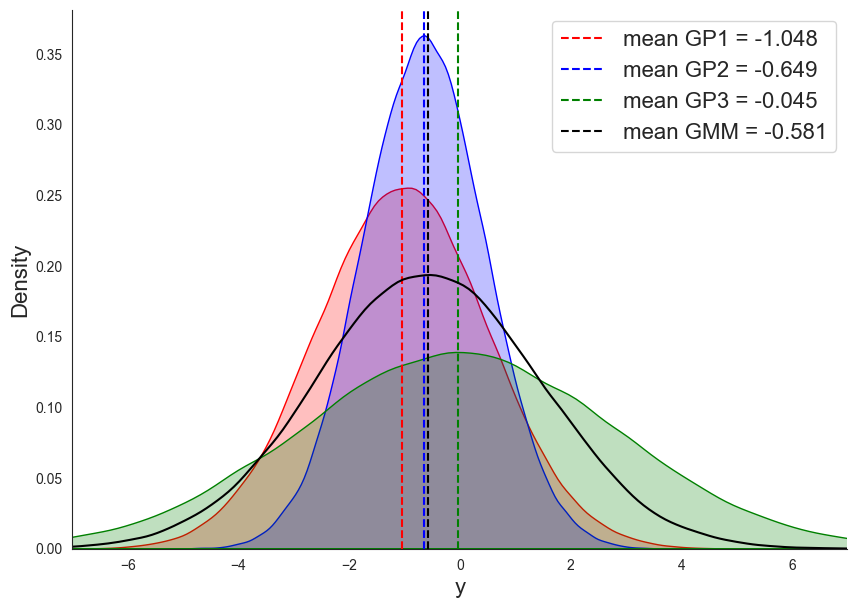

In [456]:
plt.figure(figsize=(10, 7))
sns.kdeplot(y1_sampled, color="red", fill=True)
plt.axvline(x=y1_sampled.mean(), color='red', linestyle='--', label=f'mean GP1 = {round(y1_sampled.mean(),3)}')
sns.kdeplot(y2_sampled, color="blue", fill=True)
plt.axvline(x=y2_sampled.mean(), color='blue', linestyle='--', label=f'mean GP2 = {round(y2_sampled.mean(),3)}')
sns.kdeplot(y3_sampled, color="green", fill=True)
plt.axvline(x=y3_sampled.mean(), color='green', linestyle='--', label=f'mean GP3 = {round(y3_sampled.mean(),3)}')
sns.kdeplot(MM_normal, color="black", fill=False)
plt.axvline(x=mu_gmm, color='black', linestyle='--', label=f'mean GMM = {round(mu_gmm,3)}')
plt.legend(fontsize=16)
plt.xlabel("y", fontsize=16)
sns.despine() 
plt.ylabel("Density", fontsize=16)
plt.xlim(-7, 7)  # Set x-axis limits
plt.savefig('MM_GMM_posterior.png')
plt.grid(False)  # Ensure grid remains removed
plt.show()

In [69]:
n=10

class NewExactGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, dim, tkwargs):
        super(NewExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean().to(**tkwargs)
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=dim)
        ).to(**tkwargs)


    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

train_X = SobolEngine(dimension=1, scramble=True, seed=55).draw(4).to(**tkwargs)
train_Y = torch.sin(train_X*2*3.14)

new_likelihood = gpytorch.likelihoods.GaussianLikelihood().to(**tkwargs)
# Given parameters
new_model = NewExactGPModel(train_X, train_Y.squeeze(), new_likelihood,1, tkwargs)
new_model.train()
new_likelihood.train()
#new_model.set_train_data(train_X, train_Y.squeeze(), strict=False)
optimizer = torch.optim.Adam(new_model.parameters(), lr=0.1, foreach=False )  # Includes GaussianLikelihood parameters
#mll = get_mll_best_model(gp, best_gp_index, train_X, train_Y, test_X, test_Y)
best_loss = float('inf')
patience = 15  # Adjust this value based on your preference
mll = gpytorch.mlls.ExactMarginalLogLikelihood(new_likelihood, new_model)
for i in range(100):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    output = new_model(train_X)
    loss = -mll(output, train_Y.squeeze())
    loss.backward()
    #if print_iter:
    if i == 0 or loss.item() < best_loss:
        best_loss = loss.item()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            #if print_iter:
            #print(f'Early stopping at iteration {i + 1} with best loss: {best_loss}')
            break
    optimizer.step()
    #maybe add likelihoods to the model parameters
#ll = mll(output, train_Y.squeeze())
new_model.eval()
new_likelihood.eval()
X_test = torch.tensor(np.arange(0,1,1/100)).unsqueeze(-1)
with torch.no_grad():
    observed_pred =new_model(X_test)

    # All relevant settings for using CIQ.
    #   ciq_samples(True) - Use CIQ for sampling
    #   num_contour_quadrature(10) -- Use 10 quadrature sites (Q in the paper)
    #   minres_tolerance -- error tolerance from minres (here, <0.01%).

    print("Running with Cholesky")
    # Make sure we use Cholesky
    with gpytorch.settings.fast_computations(covar_root_decomposition=True):
        %time y_samples = observed_pred.rsample(sample_shape=torch.Size([n]))

Running with Cholesky
CPU times: total: 0 ns
Wall time: 2 ms


In [70]:
ys = y_samples.detach().numpy()

In [71]:
import matplotlib.pyplot as plt

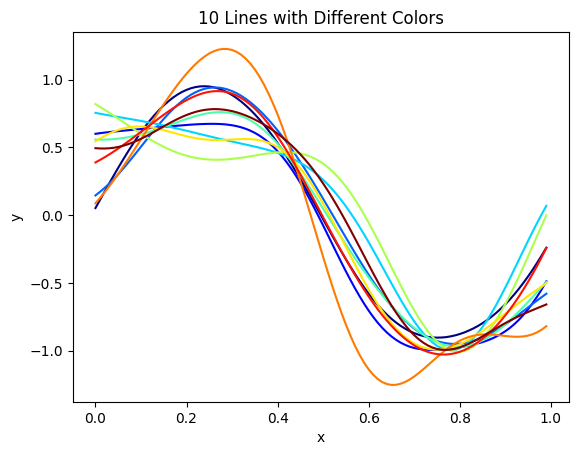

In [72]:
colors = plt.cm.jet(np.linspace(0, 1, n))

# Plotting n lines with different colors
for i in range(n):
    plt.plot(X_test, ys[i], color=colors[i])

plt.title(f'{n} Lines with Different Colors')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


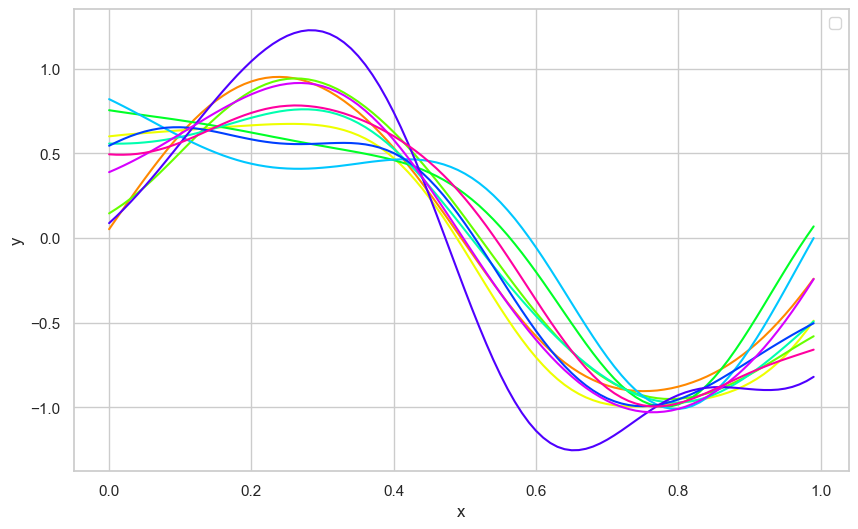

In [75]:
import seaborn as sns

# Set Seaborn style
sns.set(style='whitegrid')

# Create the plot again with Seaborn enhancements
plt.figure(figsize=(10, 6))

# Use a Seaborn color palette
palette = sns.color_palette("hsv", n)

for i in range(n):
    plt.plot(X_test, ys[i], color=palette[i])


plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

C:\Users\felip\AppData\Local\Temp\ipykernel_10432\3450724806.py:26: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=x.ravel(), y=y_samples[:, j], ax=axes[i], palette='hsv')
C:\Users\felip\AppData\Local\Temp\ipykernel_10432\3450724806.py:26: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=x.ravel(), y=y_samples[:, j], ax=axes[i], palette='hsv')
C:\Users\felip\AppData\Local\Temp\ipykernel_10432\3450724806.py:26: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=x.ravel(), y=y_samples[:, j], ax=axes[i], palette='hsv')
C:\Users\felip\AppData\Local\Temp\ipykernel_10432\3450724806.py:26: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=x.ravel(), y=y_samples[:, j], ax=axes[i], palette='hsv')
C:\Users\felip\AppData\Local\Temp\ipykernel_10432\3450724806.py:26: UserWarning: Ignoring `palette` because no `hue` variabl

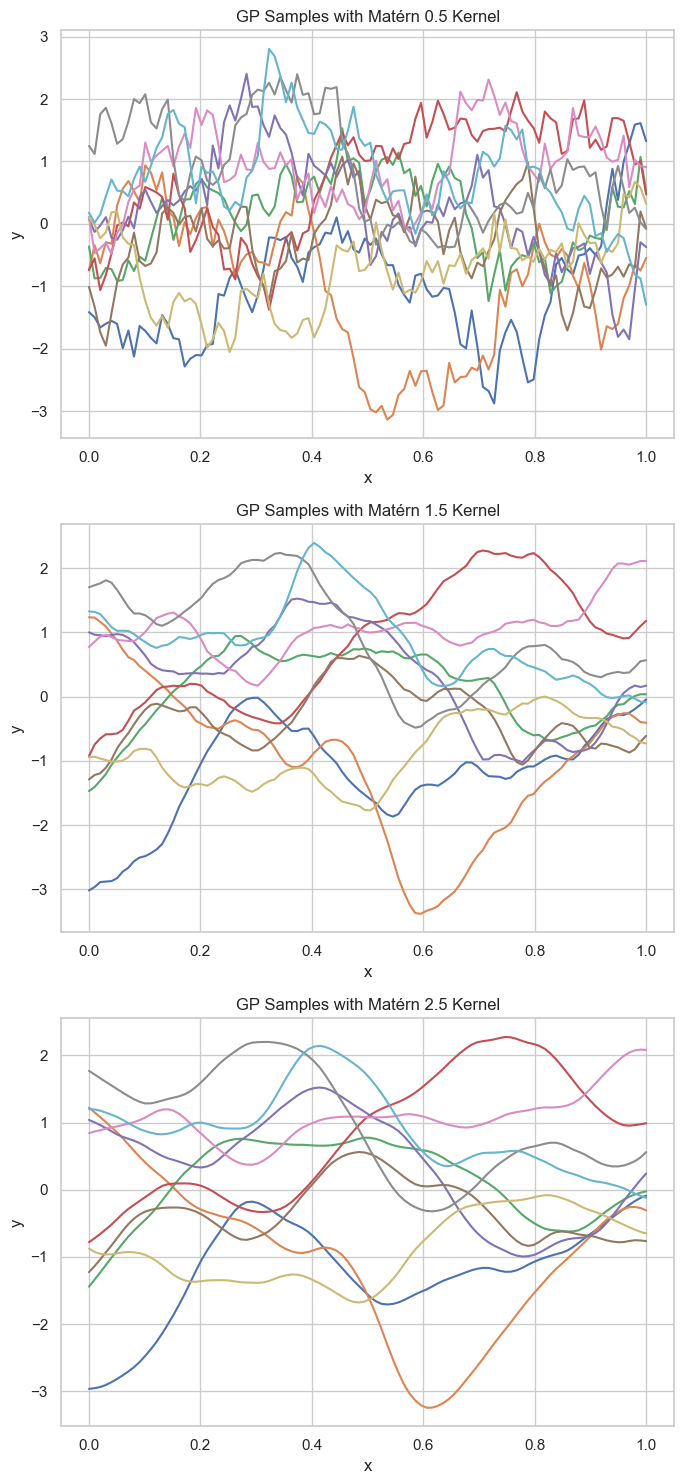

In [84]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern

# Define the x values
x = np.linspace(0, 1, 100).reshape(-1, 1)

# Define the Matérn kernels with different smoothness parameters (nu)
kernels = [Matern(length_scale=0.2, nu=0.5),
           Matern(length_scale=0.2, nu=1.5),
           Matern(length_scale=0.2, nu=2.5)]

# Number of samples
n_samples = 10

# Plot settings
fig, axes = plt.subplots(3, 1, figsize=(7, 15))
nu_values = [0.5, 1.5, 2.5]

for i, kernel in enumerate(kernels):
    gp = GaussianProcessRegressor(kernel=kernel)
    
    # Generate samples
    y_samples = gp.sample_y(x, n_samples)
    
    for j in range(n_samples):
        sns.lineplot(x=x.ravel(), y=y_samples[:, j], ax=axes[i], palette='hsv')
    
    axes[i].set_title(f'GP Samples with Matérn {nu_values[i]} Kernel')
    axes[i].set_xlabel('x')
    axes[i].set_ylabel('y')

plt.tight_layout()
plt.show()


C:\Users\felip\AppData\Local\Temp\ipykernel_10432\421834713.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=x.ravel(), y=y_samples[:, j], ax=ax, palette='hsv')
C:\Users\felip\AppData\Local\Temp\ipykernel_10432\421834713.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=x.ravel(), y=y_samples[:, j], ax=ax, palette='hsv')
C:\Users\felip\AppData\Local\Temp\ipykernel_10432\421834713.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=x.ravel(), y=y_samples[:, j], ax=ax, palette='hsv')
C:\Users\felip\AppData\Local\Temp\ipykernel_10432\421834713.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=x.ravel(), y=y_samples[:, j], ax=ax, palette='hsv')
C:\Users\felip\AppData\Local\Temp\ipykernel_10432\421834713.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sn

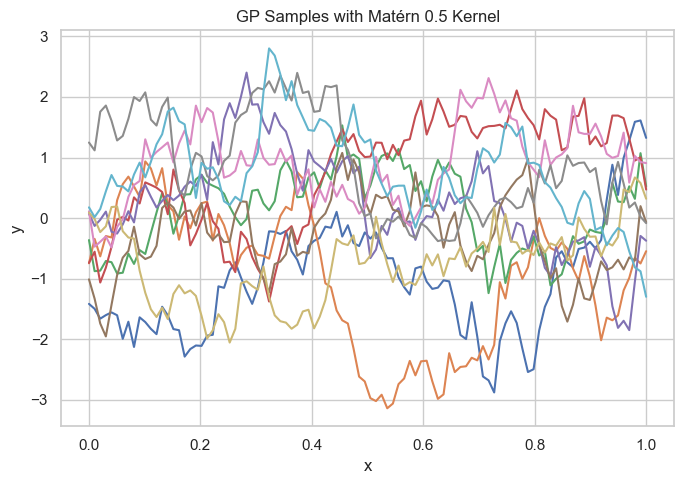

C:\Users\felip\AppData\Local\Temp\ipykernel_10432\421834713.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=x.ravel(), y=y_samples[:, j], ax=ax, palette='hsv')
C:\Users\felip\AppData\Local\Temp\ipykernel_10432\421834713.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=x.ravel(), y=y_samples[:, j], ax=ax, palette='hsv')
C:\Users\felip\AppData\Local\Temp\ipykernel_10432\421834713.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=x.ravel(), y=y_samples[:, j], ax=ax, palette='hsv')
C:\Users\felip\AppData\Local\Temp\ipykernel_10432\421834713.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=x.ravel(), y=y_samples[:, j], ax=ax, palette='hsv')
C:\Users\felip\AppData\Local\Temp\ipykernel_10432\421834713.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sn

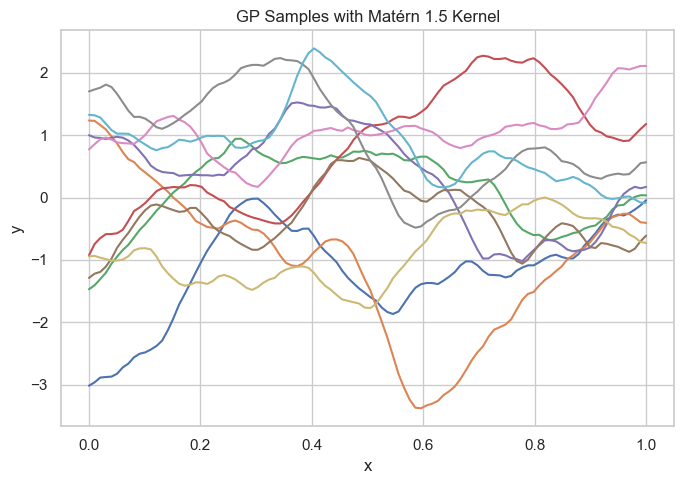

C:\Users\felip\AppData\Local\Temp\ipykernel_10432\421834713.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=x.ravel(), y=y_samples[:, j], ax=ax, palette='hsv')
C:\Users\felip\AppData\Local\Temp\ipykernel_10432\421834713.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=x.ravel(), y=y_samples[:, j], ax=ax, palette='hsv')
C:\Users\felip\AppData\Local\Temp\ipykernel_10432\421834713.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=x.ravel(), y=y_samples[:, j], ax=ax, palette='hsv')
C:\Users\felip\AppData\Local\Temp\ipykernel_10432\421834713.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=x.ravel(), y=y_samples[:, j], ax=ax, palette='hsv')
C:\Users\felip\AppData\Local\Temp\ipykernel_10432\421834713.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sn

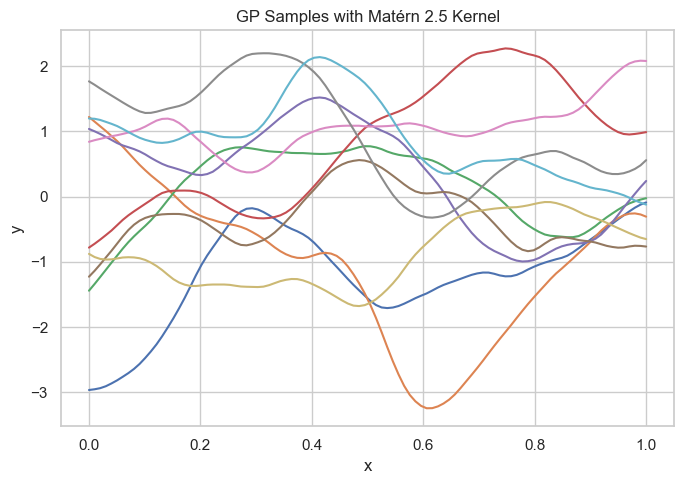

In [85]:
# Generating and plotting the samples in three separate standalone plots

for i, kernel in enumerate(kernels):
    fig, ax = plt.subplots(figsize=(7, 5))
    gp = GaussianProcessRegressor(kernel=kernel)
    
    # Generate samples
    y_samples = gp.sample_y(x, n_samples)
    
    for j in range(n_samples):
        sns.lineplot(x=x.ravel(), y=y_samples[:, j], ax=ax, palette='hsv')
    
    ax.set_title(f'GP Samples with Matérn {nu_values[i]} Kernel')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    
    plt.tight_layout()
    plt.savefig('')
    plt.show()


C:\Users\felip\AppData\Local\Temp\ipykernel_10432\3315335045.py:34: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=x.ravel(), y=y_samples_se[:, j], palette='hsv')
C:\Users\felip\AppData\Local\Temp\ipykernel_10432\3315335045.py:34: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=x.ravel(), y=y_samples_se[:, j], palette='hsv')
C:\Users\felip\AppData\Local\Temp\ipykernel_10432\3315335045.py:34: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=x.ravel(), y=y_samples_se[:, j], palette='hsv')
C:\Users\felip\AppData\Local\Temp\ipykernel_10432\3315335045.py:34: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=x.ravel(), y=y_samples_se[:, j], palette='hsv')
C:\Users\felip\AppData\Local\Temp\ipykernel_10432\3315335045.py:34: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(

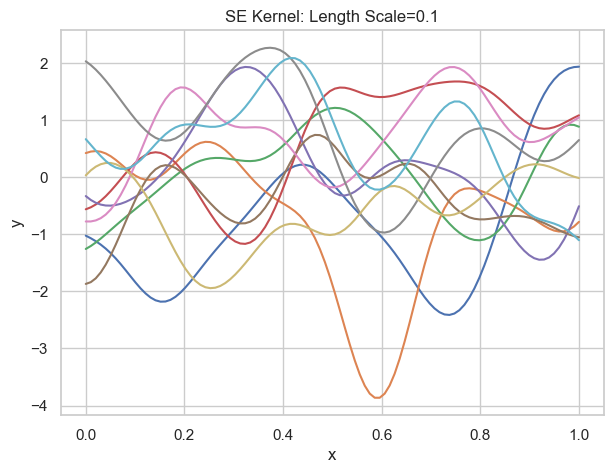

C:\Users\felip\AppData\Local\Temp\ipykernel_10432\3315335045.py:34: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=x.ravel(), y=y_samples_se[:, j], palette='hsv')
C:\Users\felip\AppData\Local\Temp\ipykernel_10432\3315335045.py:34: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=x.ravel(), y=y_samples_se[:, j], palette='hsv')
C:\Users\felip\AppData\Local\Temp\ipykernel_10432\3315335045.py:34: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=x.ravel(), y=y_samples_se[:, j], palette='hsv')
C:\Users\felip\AppData\Local\Temp\ipykernel_10432\3315335045.py:34: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=x.ravel(), y=y_samples_se[:, j], palette='hsv')
C:\Users\felip\AppData\Local\Temp\ipykernel_10432\3315335045.py:34: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(

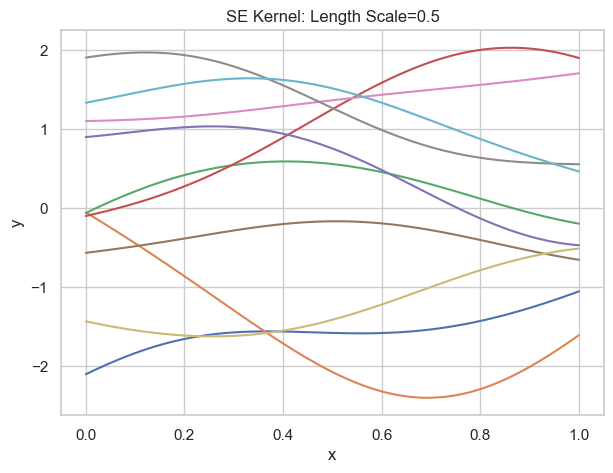

C:\Users\felip\AppData\Local\Temp\ipykernel_10432\3315335045.py:34: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=x.ravel(), y=y_samples_se[:, j], palette='hsv')
C:\Users\felip\AppData\Local\Temp\ipykernel_10432\3315335045.py:34: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=x.ravel(), y=y_samples_se[:, j], palette='hsv')
C:\Users\felip\AppData\Local\Temp\ipykernel_10432\3315335045.py:34: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=x.ravel(), y=y_samples_se[:, j], palette='hsv')
C:\Users\felip\AppData\Local\Temp\ipykernel_10432\3315335045.py:34: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=x.ravel(), y=y_samples_se[:, j], palette='hsv')
C:\Users\felip\AppData\Local\Temp\ipykernel_10432\3315335045.py:34: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(

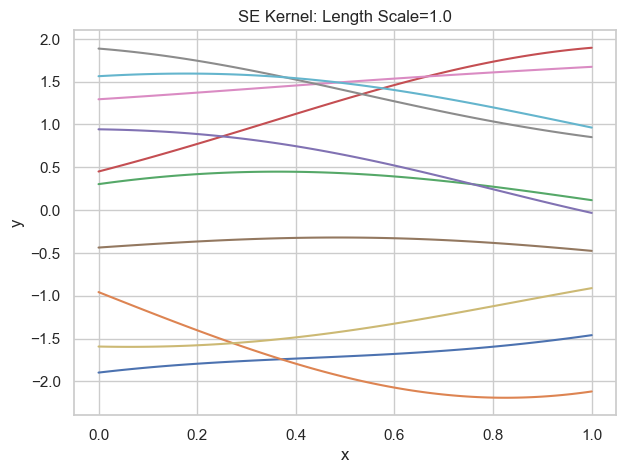

In [86]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

# Define the x values
x = np.linspace(0, 1, 100).reshape(-1, 1)

# Number of samples
n_samples = 10

# Define three SE kernels with different length scales
length_scales = [0.1, 0.5, 1.0]  # Different length scale values
se_kernels = [RBF(length_scale=ls) for ls in length_scales]

# Titles for the plots
titles = [
    f'SE Kernel: Length Scale={length_scales[0]}',
    f'SE Kernel: Length Scale={length_scales[1]}',
    f'SE Kernel: Length Scale={length_scales[2]}'
]

# Generating and plotting the samples
for i, kernel in enumerate(se_kernels):
    gp_se = GaussianProcessRegressor(kernel=kernel)
    
    # Generate samples
    y_samples_se = gp_se.sample_y(x, n_samples)
    
    # Plotting
    plt.figure(figsize=(7, 5))
    for j in range(n_samples):
        sns.lineplot(x=x.ravel(), y=y_samples_se[:, j], palette='hsv')
    
    plt.title(titles[i])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()


In [ ]:
import GPy
import numpy as np
import matplotlib.pyplot as plt

# Define the x values for plotting
x = np.linspace(0, 1, 100).reshape(-1, 1)

# Number of samples and spectral mixture components
n_samples = 10
n_mixtures = 4  # For example, using 4 mixture components

# Define a Spectral Mixture kernel with GPy
kernel = GPy.kern.SM(input_dim=1, num_mixtures=n_mixtures)

# Create a Gaussian Process model with the SM kernel
model = GPy.models.GPRegression(None, None, kernel)
model.randomize()  # Randomize the parameters of the kernel

# Sample from the GP prior
y_samples = model.posterior_samples_f(x, size=n_samples).squeeze()

# Plotting the samples
plt.figure(figsize=(8, 5))
for i in range(n_samples):
    plt.plot(x, y_samples[:, i], label=f'Sample {i+1}')
plt.title('GP Samples with Spectral Mixture Kernel')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
